# NSE for Low flow regimes

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)


In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [7]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [8]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

In [56]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df = metric_df.set_index("station_id")
metric_df.head()

,nse,kge,mse,fhv,fms,flv
station_id,,,,,,
10002,0.898328,0.857653,0.229347,-10.042169,20.175607,4.281218
10003,0.926555,0.881110,0.111980,-6.074578,1.342742,28.237229
1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474
101002,0.757246,0.647206,0.300506,-25.176707,-4.734227,73.409471
101005,0.824926,0.796430,0.208704,-18.346511,1.971726,45.197245


# Explore NSE calc

In [73]:
low_flow = static.q_mean.quantile(q=0.05).values
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

low_sid = static.where(static.q_mean == find_nearest(static.q_mean, low_flow), drop=True).station_id.values[0]

flow_variability = ds["discharge_spec"].std("time")
max_var = flow_variability.where(flow_variability == flow_variability.max(), drop=True).station_id
min_var = flow_variability.where(flow_variability == flow_variability.min(), drop=True).station_id

q05_flow_var = flow_variability.quantile(q=0.05).values
min_var = flow_variability.where(flow_variability == find_nearest(flow_variability, q05_flow_var), drop=True).station_id

In [75]:
lstm_preds

<xarray.Dataset>
Dimensions:     (station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    obs         (station_id, time) float64 2.14 1.81 4.57 3.3 ... 1.18 1.04 0.94
    sim         (station_id, time) float64 1.831 2.051 2.74 ... 3.052 2.835

Text(0.5, 1.0, '54024 NSE: 0.90')

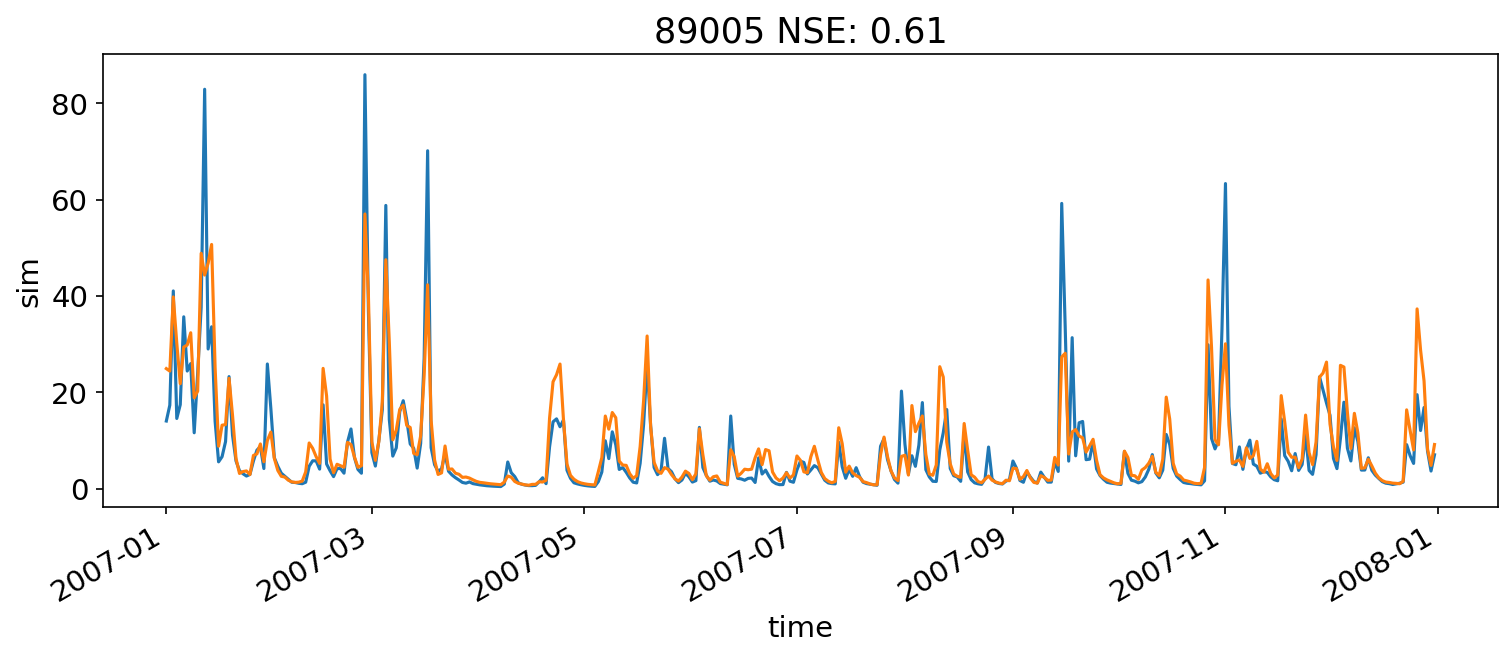

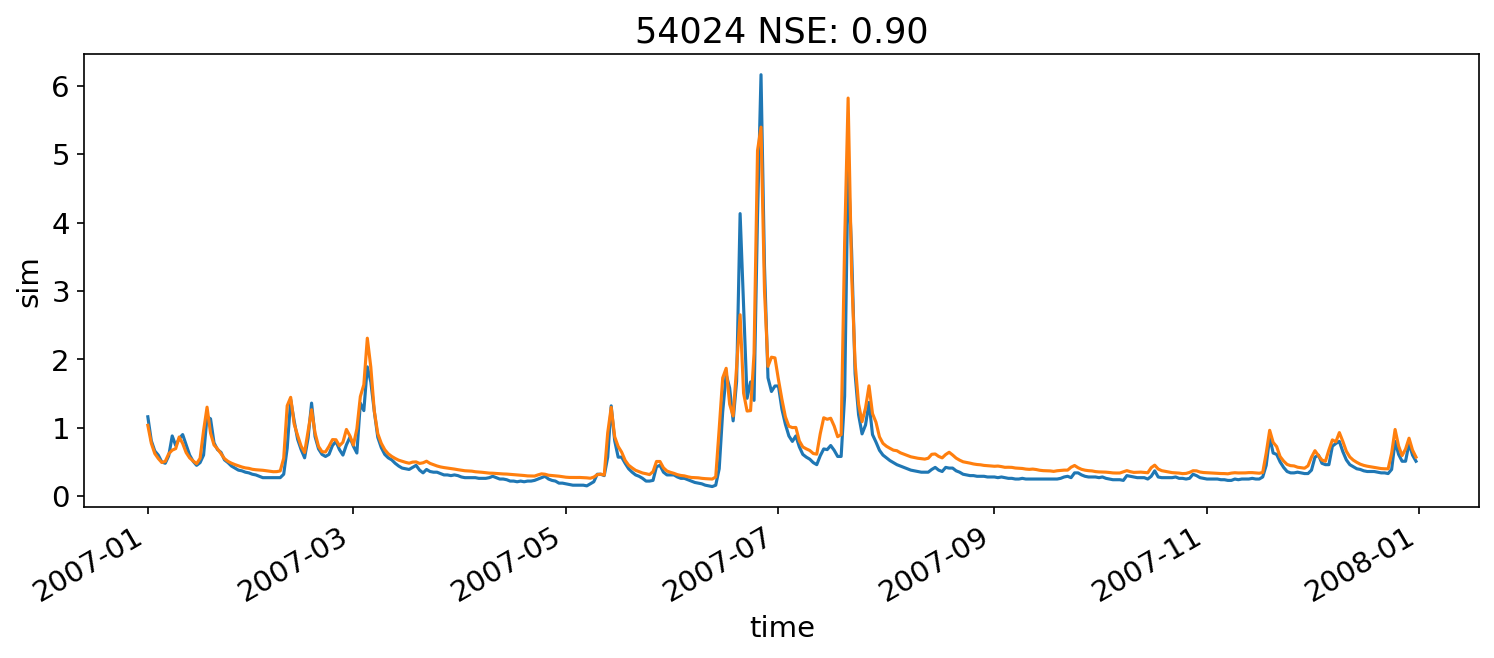

In [76]:
year = "2007"

f, ax = plt.subplots(figsize=(12, 4))
ds["discharge_spec"].sel(station_id=max_var, time=year).plot(ax=ax)
lstm_preds["sim"].sel(station_id=max_var, time=year).plot(ax=ax)
ax.set_title(f"{int(max_var)} NSE: {float(metric_df.loc[max_var, 'nse']):.2f}")
f, ax = plt.subplots(figsize=(12, 4))
ds["discharge_spec"].sel(station_id=min_var, time=year).plot(ax=ax)
lstm_preds["sim"].sel(station_id=min_var, time=year).plot(ax=ax)
ax.set_title(f"{int(min_var)} NSE: {float(metric_df.loc[min_var, 'nse']):.2f}")

In [69]:
# from hydroeval import evaluator, nse, kge

In [ ]:
def nse(qsim, qobs):
    np.isfinite(qsim)
    np.isfinite(qobs)